In [1]:
import numpy as np
from scipy.optimize import least_squares

In [2]:
import sys
sys.path.append('../../m1epma')
sys.path.append('m1epma')
import physics
import experiment
from physics import keV, nano
import optimization
import m1model
import pickle
import scipy.constants
import matplotlib.pyplot as plt
import matplotlib

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

plt.rc('axes', titlesize='small')     # fontsize of the axes title
plt.rc('axes', labelsize='small')    # fontsize of the x and y labels
plt.rc('legend', fontsize='small')    # legend fontsize


In [3]:
elements = [physics.Copper(), physics.Manganese()]
x_rays = [physics.XRay(e, 1.) for e in elements]

materials = [
    physics.Material(
        n_x = 10,
        n_y = 10,
        hat_n_x = 40*2**i,
        hat_n_y = 30*2**i,
        dim_x = [0., 1000.*nano],
        dim_y = [-800.*nano, 0.]) for i in range(0, 4)
]

detectors = [
    physics.Detector(
        x=500.*nano,
        y=50.*nano,
        material = m) for m in materials
]

beam = physics.ElectronBeam(
        size=[(30.*nano)**2, (30.*nano)**2],
        pos=[500.*nano, -100.*nano],
        beam_energy_keV=12.,
        energy_variation_keV=0.1
    )

In [4]:
experiments = [
    experiment.Experiment(
        material=m,
        detector=d,
        electron_beam=beam,
        elements=elements,
        x_ray_transitions=x_rays,
        epsilon_initial_keV=13.,
        epsilon_cutoff_keV=5.,
        n_epsilon=n_eps
    ) for (m, d, n_eps) in zip(materials, detectors, [350, 350, 350, 350, 350])]
n_x_ray_transitions = experiments[0].n_x_ray_transitions

In [5]:
for e in experiments:
    e.update_std_intensities()

calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution


In [6]:
true_parameters = np.array(
    [
        [0.78, 0.72, 0.71, 0.65, 0.2 , 0.09, 0.97, 0.17, 0.62, 0.85],
        [0.03, 0.16, 0.78, 0.28, 0.23, 0.45, 0.09, 0.06, 0.97, 0.67],
        [0.6 , 0.49, 0.09, 0.48, 0.07, 0.27, 0.76, 0.95, 0.03, 0.09],
        [0.96, 0.64, 0.4 , 0.26, 0.8 , 0.93, 0.19, 0.9 , 0.87, 0.08],
        [0.16, 0.9 , 0.5 , 0.83, 0.62, 0.41, 0.19, 0.32, 0.61, 0.36],
        [0.62, 0.75, 0.47, 0.61, 0.68, 0.65, 0.98, 0.35, 0.14, 0.94],
        [0.72, 0.78, 0.96, 0.44, 0.03, 0.66, 0.16, 0.56, 0.72, 0.21],
        [0.  , 0.38, 0.86, 0.55, 0.21, 0.66, 0.49, 0.44, 0.66, 0.11],
        [0.81, 0.19, 0.58, 0.8 , 0.63, 0.77, 0.82, 0.32, 0.97, 0.64],
        [0.48, 0.05, 0.16, 0.56, 0.49, 0.46, 0.58, 0.04, 0.84, 1.  ]
    ]
).reshape((materials[0].n_x, materials[0].n_y, 1))
n_parameters = materials[0].n_x*materials[0].n_y
variable_parameters = [(3, -1, 0), (4, -1, 0), (5, -1, 0), (6, -1, 0), (3, -2, 0), (4, -2, 0), (5, -2, 0), (6, -2, 0)]
variable_parameters = [(4, -1, 0), (5, -1, 0), (4, -2, 0), (5, -2, 0)]
n_k_ratios = sum([e.n_x_ray_transitions for e in experiments])
[true_parameters[i] for i in variable_parameters]


[0.36, 0.94, 0.61, 0.14]

In [7]:
solution0 = m1model.solve_forward(experiments[0], experiment.mass_fractions_from_parameters(experiments[0].material.n_x, experiments[0].material.n_y, true_parameters))
solution1 = m1model.solve_forward(experiments[1], experiment.mass_fractions_from_parameters(experiments[1].material.n_x, experiments[1].material.n_y, true_parameters))
solution2 = m1model.solve_forward(experiments[2], experiment.mass_fractions_from_parameters(experiments[2].material.n_x, experiments[2].material.n_y, true_parameters))
solution3 = m1model.solve_forward(experiments[3], experiment.mass_fractions_from_parameters(experiments[3].material.n_x, experiments[3].material.n_y, true_parameters))


calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution


In [8]:
k_ratios_0 = experiment.k_ratios(experiments[0], true_parameters)
k_ratios_1 = experiment.k_ratios(experiments[1], true_parameters)
k_ratios_2 = experiment.k_ratios(experiments[2], true_parameters)
k_ratios_3 = experiment.k_ratios(experiments[3], true_parameters)


calculating forward solution
calculating forward solution
calculating forward solution
calculating forward solution


In [10]:
with open("convergence_solution_k_ratios.pkl", "wb") as writefile:
    pickle.dump(
    (solution0, solution1, solution2, solution3, k_ratios_0, k_ratios_1, k_ratios_2, k_ratios_3), writefile)

In [5]:
with open("convergence_solution_k_ratios.pkl", "rb") as readfile:
    solution0, solution1, solution2, solution3, k_ratios_0, k_ratios_1, k_ratios_2, k_ratios_3 = pickle.load(readfile)

In [6]:
def l2_norm(f, g, n):
    #n: n * n_cells(f) = n_cells(g)
    scal = np.ones((n, n))

    norm = 0.
    for i in range(f['solution'].shape[0]): # time loop
        for j in range(0, 3): # 
            temp = f['solution'][i, j, :, :]
            norm += np.sum(np.power(np.kron(temp, scal) - g['solution'][i, j, :, :], 2))
    return np.sqrt(norm*g['delta_x']*g['delta_y']*experiments[0].delta_epsilon_J)

norm = [l2_norm(solution0, solution3, 8), l2_norm(solution1, solution3, 4), l2_norm(solution2, solution3, 2)]


In [7]:
norm_k_rat = [np.linalg.norm(k_ratios_3 - k_ratios_0), np.linalg.norm(k_ratios_3 - k_ratios_1), np.linalg.norm(k_ratios_3 - k_ratios_2)]
scale = np.array([exp.material.delta_x / scipy.constants.nano for exp in experiments[0:3]])

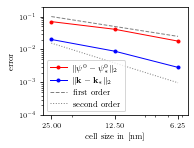

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(2.6, 2))

plt.loglog(scale, norm, label="$|| \psi^0 - \psi^0_{*}||_2$", marker="o", color="red", linewidth=1, markersize=3)
plt.loglog(scale, norm_k_rat, label="$|| \mathbf{k} - \mathbf{k}_{*}||_2$", marker="o", color="blue", linewidth=1, markersize=3)
plt.loglog(scale, 0.004*scale, label="first order", color="gray", linestyle="dashed", linewidth=1)
plt.loglog(scale, 0.000025*scale**2, label="second order", color="gray", linestyle="dotted", linewidth=1)
plt.xlim([scale.max() + scale.max()*0.1, scale.min() - scale.min()*0.1])
plt.ylim((10e-5, 2e-1))
plt.legend()

from matplotlib.ticker import ScalarFormatter, NullFormatter
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().xaxis.set_minor_formatter(NullFormatter())
plt.gca().set_xticks(scale)

#plt.gca().get_xaxis().set_tick_params(which='minor', size=0)
#plt.gca().get_xaxis().set_tick_params(which='minor', width=0)

#plt.xticks(scale)
#plt.xticks([12.5, 25, 50])
#plt.gca().set_yticklabels(["12.5", "25", "50"])

plt.xlabel("cell size in [nm]")
plt.ylabel("error")

plt.savefig("convergence.pdf", bbox_inches='tight')
